In [1]:
%run imports.ipynb
%run _shared_setup.ipynb

docker image: podpearson/biipy_rdp:latest


In [2]:
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
output_dir = '/nfs/team112_internal/rp7/data/pf3k/analysis/20160203_check_jason_mixtures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [3]:
mixtures_ids = np.array(["PG%04d-C" % n for n in range(389, 416)])

In [4]:
sites_npy_fn = "%s/SNP_INDEL_WG.combined.filtered.mixtures.vcf.gz.vcfnp_cache/variants.npy" % (release5_final_files_dir)
biallelic_sites_npy_fn = "%s/SNP_INDEL_WG.combined.filtered.mixtures_biallelic.vcf.gz.vcfnp_cache/variants.npy" % (release5_final_files_dir)
calldata_npy_fn = "%s/SNP_INDEL_WG.combined.filtered.mixtures.vcf.gz.vcfnp_cache/calldata_2d.npy" % (release5_final_files_dir)
biallelic_calldata_npy_fn = "%s/SNP_INDEL_WG.combined.filtered.mixtures_biallelic.vcf.gz.vcfnp_cache/calldata_2d.npy" % (release5_final_files_dir)


In [5]:
sites_array_fn = os.path.join(output_dir, 'sites_array.npy')
biallelic_sites_array_fn = os.path.join(output_dir, 'biallelic_sites_array.npy')

if os.path.exists(sites_array_fn):
    sites_array = np.load(sites_array_fn)
else:
    sites_array = np.load(sites_npy_fn)[['FILTER_PASS', 'is_snp', 'STR', 'num_alleles']]
    np.save(sites_array_fn, sites_array)

if os.path.exists(biallelic_sites_array_fn):
    biallelic_sites_array = np.load(biallelic_sites_array_fn)
else:
    biallelic_sites_array = np.load(biallelic_sites_npy_fn)[['FILTER_PASS', 'is_snp', 'STR', 'num_alleles']]
    np.save(biallelic_sites_array_fn, biallelic_sites_array)



In [6]:
def as_frac_genotype(ref_reads, alt_reads, min_ad_for_minor_call=2, min_ad_for_call=5):
    if (ref_reads + alt_reads) < min_ad_for_call:
        return np.nan
    elif ref_reads < min_ad_for_minor_call:
        return 1.0
    elif alt_reads < min_ad_for_minor_call:
        return 0.0
    else:
        return alt_reads / (ref_reads + alt_reads)
as_frac_genotype = np.vectorize(as_frac_genotype, otypes=[np.float])        

In [7]:
nraf_fn = os.path.join(output_dir, 'nraf.npy')
if os.path.exists(nraf_fn):
    nraf = np.load(nraf_fn)
else:
    AD_array = np.load(calldata_npy_fn)['AD']
    nraf = as_frac_genotype(AD_array[:, :, 0], np.sum(AD_array[:, :, 1:8]))
    np.save(nraf_fn, nraf)
    del(AD_array)
    gc.collect()

biallelic_nraf_fn = os.path.join(output_dir, 'biallelic_nraf.npy')
if os.path.exists(biallelic_nraf_fn):
    biallelic_nraf = np.load(biallelic_nraf_fn)
else:
    biallelic_AD_array = np.load(biallelic_calldata_npy_fn)['AD']
    biallelic_nraf = as_frac_genotype(biallelic_AD_array[:, :, 0], biallelic_AD_array[:, :, 1])
    np.save(biallelic_nraf_fn, biallelic_nraf)
    del(biallelic_AD_array)
    gc.collect()


In [30]:
np.sum(AD_array[:, :, 1:8]).shape

NameError: name 'AD_array' is not defined

In [8]:
dir()

['Bio',
 'CHROM_VCF_FNS',
 'CROSSES_TRAINING_FNS',
 'DATA_DIR',
 'GENOME_FN',
 'GENOME_FNS',
 'GFF_FNS',
 'GridSpec',
 'HTML',
 'INTERIM5_VCF_FOFN',
 'IPython',
 'In',
 'ListedColormap',
 'Out',
 'REGIONS_FN',
 'RELEASE4_RESOURCES_DIR',
 'SITES_H5_FNS',
 'SITES_NPY_FNS',
 'SNPEFF_DIRS',
 'WG_VCF_FNS',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 '_slog_indent',
 'allel',
 'anhima',
 'annotation_version',
 'as_frac_genotype',
 'bcolz',
 'biallelic_calldata_npy_fn',
 'biallelic_nraf',
 'biallelic_nraf_fn',
 'biallelic_sites_array',
 'biallelic_sites_array_fn',
 'biallelic_sites_npy_fn',
 'bisect',
 'calldata_npy_fn',
 'chrom',
 'clear_output',
 'collections',
 'contextlib',
 'csv',
 'cython',
 'da',
 'dask',
 'datetime',
 'display',
 'ete3',
 'etl',
 'exit',
 'functools',
 'gc',
 'get_ipython

In [31]:
np.min(biallelic_nraf)


nan

In [15]:
4212465*27*8

909892440

In [23]:
# del(biallelic_AD_array)
gc.collect()

278

In [22]:
def plot_nraf_spectra(nraf=nraf,
    variants=(sites_array['is_snp'] & sites_array['FILTER_PASS'] & (sites_array['num_alleles'] == 2)),
    ylim=500):
    
    fig = fig = plt.figure(figsize=(8.27, 11.69))
    for i, ox_code in enumerate(mixtures_ids):
        ax = fig.add_subplot(9, 3, i+1)
        _ = ax.hist(
            nraf[:, i][(nraf[:, i] >= 0.01) & (nraf[:, i] <= 0.99)],
            bins=np.arange(0.01, 1.0, 0.01)
        )
        ax.set_ylim([0, ylim])
        ax.set_title(ox_code)
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    fig.tight_layout()
    return(fig)


In [23]:
np.unique((sites_array['is_snp'] & sites_array['FILTER_PASS'] & (sites_array['num_alleles'] == 2)), return_counts=True)

(array([False,  True], dtype=bool), array([4133571,   78894]))

In [25]:
np.unique((sites_array['is_snp'] & sites_array['FILTER_PASS']), return_counts=True)

(array([False,  True], dtype=bool), array([4045121,  167344]))

In [26]:
np.unique((sites_array['FILTER_PASS']), return_counts=True)

(array([False,  True], dtype=bool), array([3500469,  711996]))

In [24]:
np.unique((sites_array['is_snp']), return_counts=True)

(array([False,  True], dtype=bool), array([1650575, 2561890]))

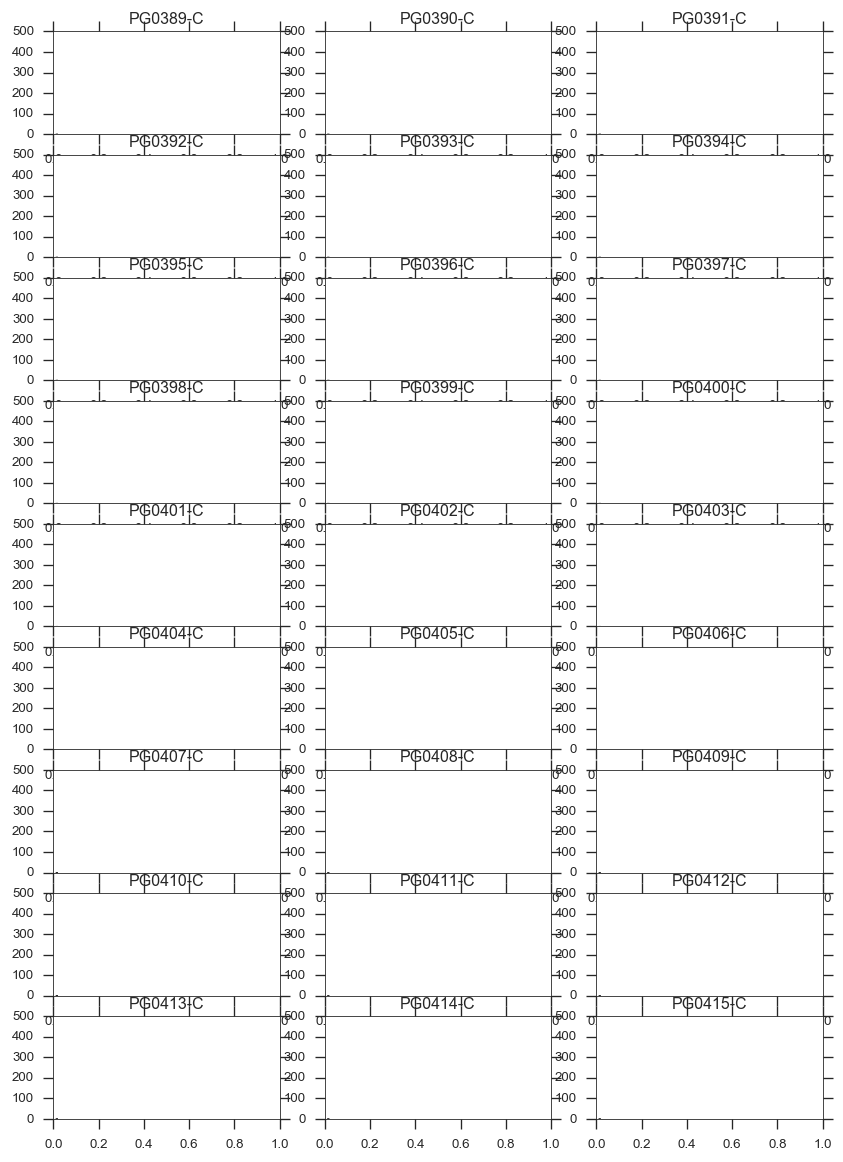

In [21]:
fig_pass_snps_biallelic = plot_nraf_spectra()
fig_pass_snps_biallelic.savefig("%s/%s.pdf" % (output_dir, 'pass_snps_biallelic'))

In [ ]:
fig_pass_indels_biallelic = plot_nraf_spectra(
    variants=(np.logical_not(sites_array['is_snp']) & sites_array['FILTER_PASS'] & (sites_array['num_alleles'] == 2))
)
fig_pass_indels_biallelic.savefig("%s/%s.pdf" % (output_dir, 'pass_indels_biallelic'))

In [ ]:
fig_all_snps_biallelic = plot_nraf_spectra(
    variants=(sites_array['is_snp'] & (sites_array['num_alleles'] == 2))
)
fig_all_snps_biallelic.savefig("%s/%s.pdf" % (output_dir, 'all_snps_biallelic'))

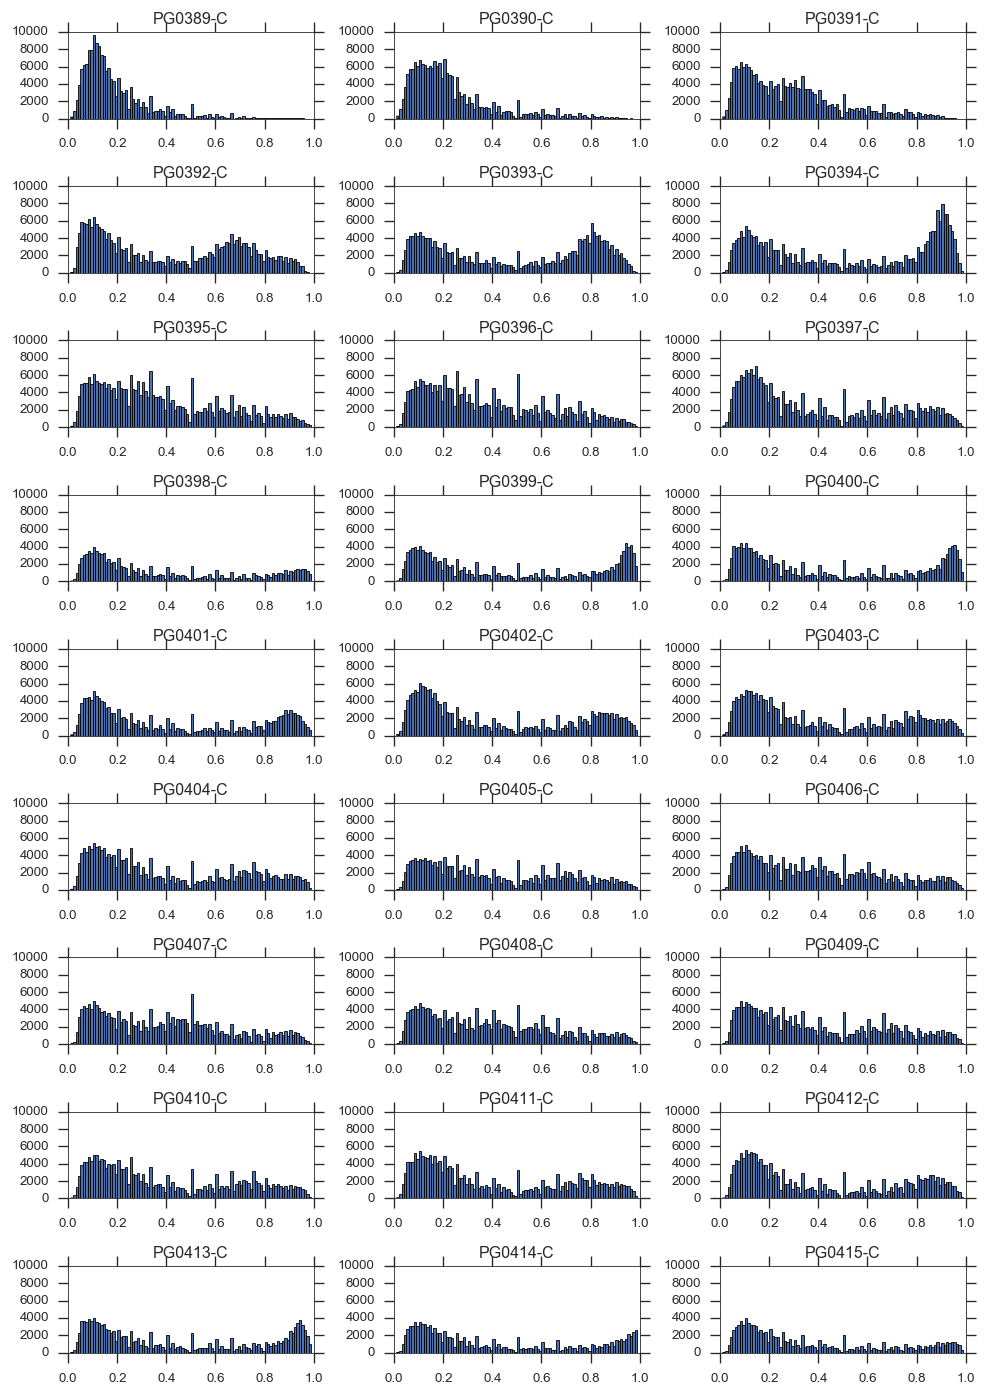

In [33]:
fig_biallelic_snps_PASS = plot_nraf_spectra(
    biallelic_nraf,
    variants=((biallelic_sites_array['is_snp']) & biallelic_sites_array['FILTER_PASS'] & (biallelic_sites_array['num_alleles'] == 2)),
    ylim=10000
)
fig_biallelic_snps_PASS.savefig("%s/%s.pdf" % (output_dir, 'biallelic_snps_PASS'))